# DATA CHALLENGE - THE ART OF THE POSSIBLE

## Estimation of daily patient count using Time Series Forecasting

### Submitted by Ashish Ahuja

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
from datetime import datetime
import numpy as np
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


### Data Loading

This section follows data cleaning approach explained in Exploratory Data Analysis notebook **EDA_basics.ipynb**

In [3]:
filename = 'Generic ED 2009.xlsx'

In [8]:
dataset = pd.read_excel(filename)

In [9]:
dataset.head()

,MRN,Presentation Visit Number,Triage Priority,Age (yrs),Arrival Date,Dr Seen Date,Depart Actual Date,Depart Status Code,Departure Status Desc.,Depart. Dest. Code,Depart. Dest. Desc.,TimeDiff Arrival-Actual Depart (mins),TimeDiff TreatDrNr-Act. Depart (mins),Presenting Complaint Code,Presenting Complaint Desc.,Diag Code,Diagnosis Desc.
0,67269,63190,3,15,2009-01-01 00:17:00,2009-01-01 02:11:00,2009-01-01 12:30:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,733,619.0,4000.0,DRUG / ALCOHOL / POISONING,F43.9,EMOTIONAL CRISIS
1,444991,63193,4,15,2009-01-01 00:35:00,2009-01-01 03:01:00,2009-01-01 07:35:00,W,DID NOT WAIT,DNW,* DID NOT WAIT,420,274.0,9000.0,INJURY,Z53.2,DID NOT WAIT
2,444992,63194,4,8,2009-01-01 00:55:00,2009-01-01 01:08:00,2009-01-01 01:08:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,13,0.0,7000.0,EYE,H10.9,CONJUNCTIVITIS
3,444999,63213,3,12,2009-01-01 03:22:00,2009-01-01 04:34:00,2009-01-01 05:00:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,98,26.0,25000.0,PAIN,H60.9,OTITIS EXTERNA
4,429921,63217,4,15,2009-01-01 03:55:00,2009-01-01 06:30:00,2009-01-01 08:29:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,274,119.0,9000.0,INJURY,S83.6,KNEE SPRAIN / STRAIN


In [11]:
dataset.columns

Index(['MRN', 'Presentation Visit Number', 'Triage Priority', ' Age  (yrs)',
       'Arrival Date', 'Dr Seen Date', 'Depart Actual Date',
       'Depart Status Code', 'Departure Status Desc.', 'Depart. Dest. Code',
       'Depart. Dest. Desc.', 'TimeDiff Arrival-Actual Depart (mins)',
       'TimeDiff TreatDrNr-Act. Depart (mins)', 'Presenting Complaint Code',
       'Presenting Complaint Desc.', 'Diag Code', 'Diagnosis Desc.'],
      dtype='object')

### Feature Engineering

Addition of a new column to the dataset representing total count of patients per day.

In [15]:
pat_date = dataset['Arrival Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
pat_date = pat_date.value_counts(sort=False).reset_index()
pat_date.head()

,index,Arrival Date
0,2010-05-27,43
1,2009-08-20,28
2,2009-05-09,46
3,2010-07-02,31
4,2010-10-29,49


In [16]:
pat_date.columns = ['Arrival Date','patient_count']
pat_date['Arrival Date'] = pd.to_datetime(pat_date['Arrival Date'],format = '%Y-%m-%d')
pat_date.sort_values(by=['Arrival Date'], inplace=True)
pat_date.head()

,Arrival Date,patient_count
311,2009-01-01,51
447,2009-01-02,25
534,2009-01-03,41
504,2009-01-04,43
446,2009-01-05,31


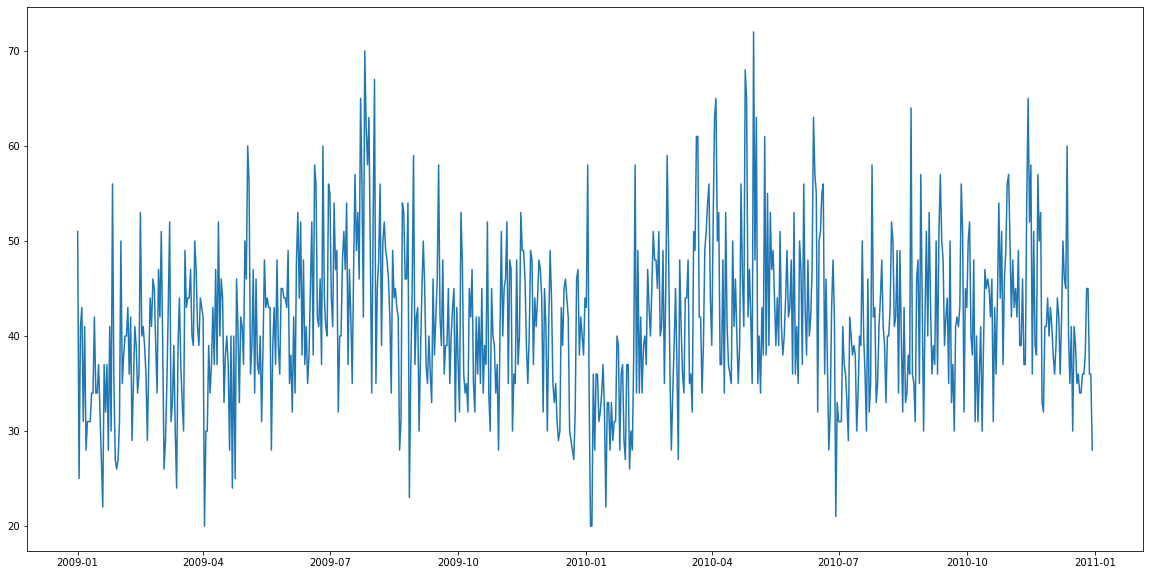

In [17]:
plt.figure(figsize=(20,10))
plt.plot(pat_date['Arrival Date'],pat_date['patient_count'])

In [19]:
ts_data = pat_date.copy(deep=True)
ts_data.columns = ['ds','y']

### Time Series Forecasting

Representing daily patient count enables us to use Time Series Forecasting methods for estimating daily patient count for any number of days in the future (horizon).

In this notebook, Prophet from FaceBook has been used for time series analysis and forecasting. 

In [36]:
horizon = 60
ts_train = ts_data.iloc[:-horizon,:]
ts_test = ts_data.iloc[-horizon:,:]

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [23]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
from sklearn.metrics import mean_absolute_error
def check_forecast(expected,predictions,time_series):
    #rmse
    mse = mean_squared_error(expected, predictions)
    rmse = sqrt(mse)
    print('RMSE =  ' + str(rmse))
    
    #mase
    mase = mean_absolute_scaled_error(expected,predictions,time_series)
    print('MASE =  ' + str(mase))

    #mae
    mae = mean_absolute_error(expected, predictions)
    print('MAE =  ' + str(mae))

    #mape
    mape = mean_absolute_percentage_error(expected, predictions)
    print('MAPE =  ' + str(mape))
    
    return(rmse,mase,mae,mape)

### Autocorelation and Partial Autocorelation plots

These plots are used to establish seasonalities present in the time series dataset. Peaks at 7 and 14 days suggest strong weekly and biweekly seasonality.

In [25]:
import statsmodels.api as sm

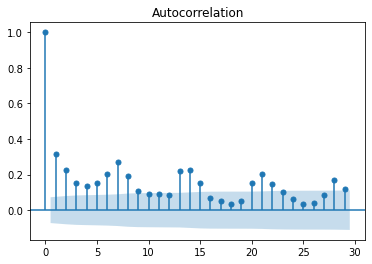

In [27]:
sm.graphics.tsa.plot_acf(ts_data.y.values)
plt.show()

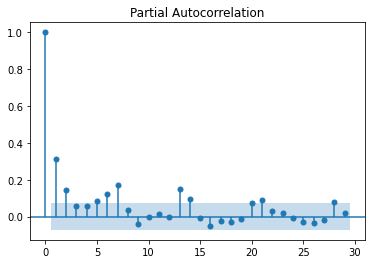

In [39]:
sm.graphics.tsa.plot_pacf(ts_data.y.values)
plt.show()

### Time Series Forecasting Using Prophet

Time series model from Prophet has been fit on the historical time series dataset. Additional searonal components for biweekly and afte 21 days have been added to the model.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


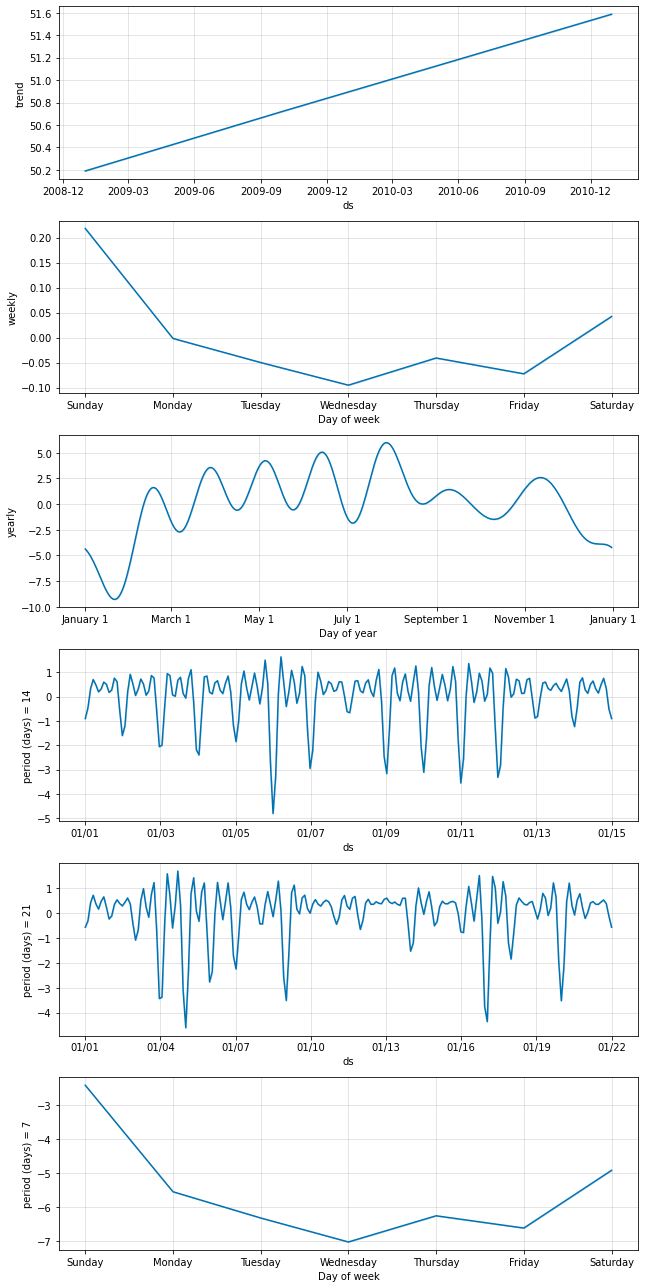

In [78]:
sea_mode = 'additive'
#sea_mode = 'multiplicative'
ff=50

m = Prophet(n_changepoints=25,changepoint_range=0.95,seasonality_mode=sea_mode,seasonality_prior_scale=1.0,yearly_seasonality=True,changepoint_prior_scale= 0.01)
#m = Prophet(yearly_seasonality=True,changepoint_prior_scale= 0.01, seasonality_prior_scale= 1.0)

m.add_seasonality(name='period (days) = ' + str(7), period=7, fourier_order=ff,mode=sea_mode)
m.add_seasonality(name='period (days) = ' + str(14), period=14, fourier_order=ff,mode=sea_mode)
m.add_seasonality(name='period (days) = ' + str(21), period=21, fourier_order=ff,mode=sea_mode)
#m.add_seasonality(name='period (days) = ' + str(34), period=34, fourier_order=ff,mode=sea_mode)
#m.add_seasonality(name='period (days) = ' + str(28), period=28, fourier_order=ff,mode=sea_mode)
m.fit(ts_train)
future = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)
fig = m.plot_components(forecast)
#expected = np.array(ts_test.y)
#predictions = np.array(forecast.tail(horizon).yhat)
#predictions = predictions.reshape(1,horizon)
#y_train = np.array(ts_test.y)
#rmse, mase = check_forecast(expected,predictions,y_train)


RMSE =  6.3561610154733135
MASE =  0.810449378085409
MAE =  5.082479150705107
MAPE =  11.897921471225775


Text(0, 0.5, 'Number of Patients per day')

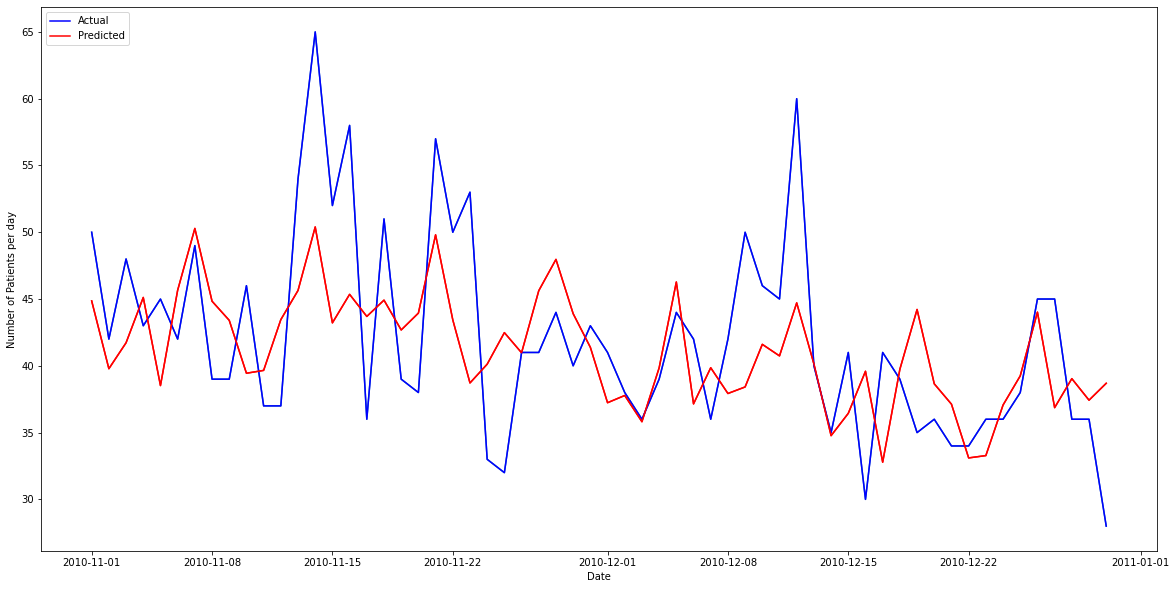

In [79]:
expected = np.array(ts_test.y)
predictions = np.array(forecast.tail(horizon).yhat)
#predictions = predictions.reshape(1,horizon)
y_test = np.array(ts_test.y)
rmse, mase , mae, mape= check_forecast(expected,predictions,y_test)
ts_predict = forecast.iloc[-horizon:,:]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(ts_test.ds,ts_test.y)
plt.plot(ts_predict.ds,ts_predict.yhat,color='r')
plt.plot(ts_test.ds,ts_test.y,color='b',label='Actual')
plt.plot(ts_predict.ds,ts_predict.yhat,color='r',label='Predicted')
plt.legend(loc="upper left")
ax.set_xlabel('Date')
ax.set_ylabel('Number of Patients per day')

In [46]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [47]:

import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ts_train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 37 forecasts with cutoffs between 2009-04-09 00:00:00 and 2010-10-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000025BA6A77988>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 37 forecasts with cutoffs between 2009-04-09 00:00:00 and 2010-10-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000025BA6D302C8>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Ru

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  9.961861
1                     0.001                     0.10  9.927208
2                     0.001                     1.00  9.947096
3                     0.001                    10.00  9.930088
4                     0.010                     0.01  8.650000
5                     0.010                     0.10  8.613267
6                     0.010                     1.00  8.573845
7                     0.010                    10.00  8.626028
8                     0.100                     0.01  8.759707
9                     0.100                     0.10  8.708992
10                    0.100                     1.00  8.720409
11                    0.100                    10.00  8.706803
12                    0.500                     0.01  9.108771
13                    0.500                     0.10  9.075869
14                    0.500                     1.00  9

In [48]:
best_params = all_params[np.argmin(rmses)]
print(best_params)


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


### Exogenous Feature

Exogenous feature represent any additional information relevant for the time series forecasting, available in the dataset. In this study a temporary (dummy) exogenous feature has been added when patient count per day is greater that 55

c:\users\aashna\anaconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


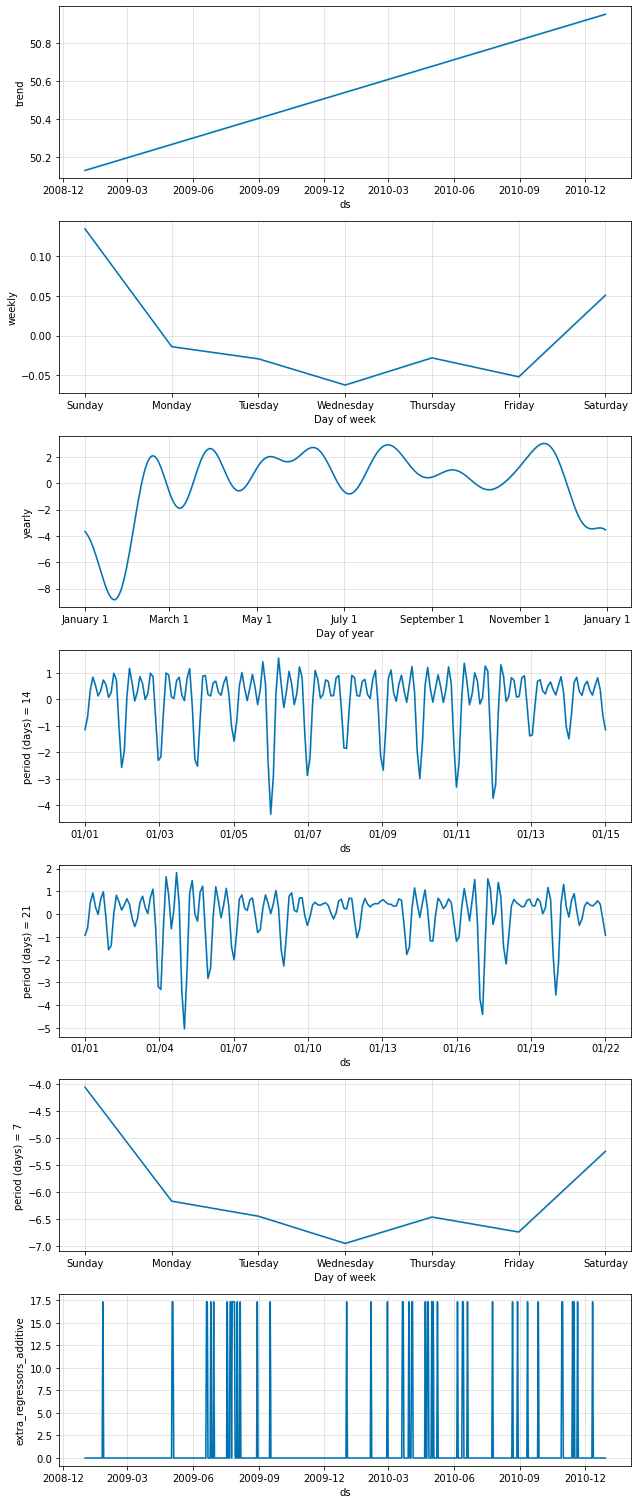

In [68]:
def p_count(y):
    #date = pd.to_datetime(ds)
    #if date.weekday() == 6 and (date.month > 8 or date.month < 2):
    if y>55:
        return 1
    else:
        return 0
ts_train['some_event'] = ts_train['y'].apply(p_count)

#m = Prophet()
m = Prophet(yearly_seasonality=True,changepoint_prior_scale= 0.01, seasonality_prior_scale= 1.0)

m.add_seasonality(name='period (days) = ' + str(7), period=7, fourier_order=ff,mode=sea_mode)
m.add_seasonality(name='period (days) = ' + str(14), period=14, fourier_order=ff,mode=sea_mode)
m.add_seasonality(name='period (days) = ' + str(21), period=21, fourier_order=ff,mode=sea_mode)

m.add_regressor('some_event')
m.fit(ts_train)

ts_data['some_event'] = ts_data['y'].apply(p_count)
future = ts_data.drop('y',axis=1)

forecast = m.predict(future)
fig = m.plot_components(forecast)

RMSE =  5.5323333312419365
MASE =  0.69634674514464
MAE =  4.366920266161303
MAPE =  10.599337492066674


Text(0, 0.5, 'Number of Patients per day')

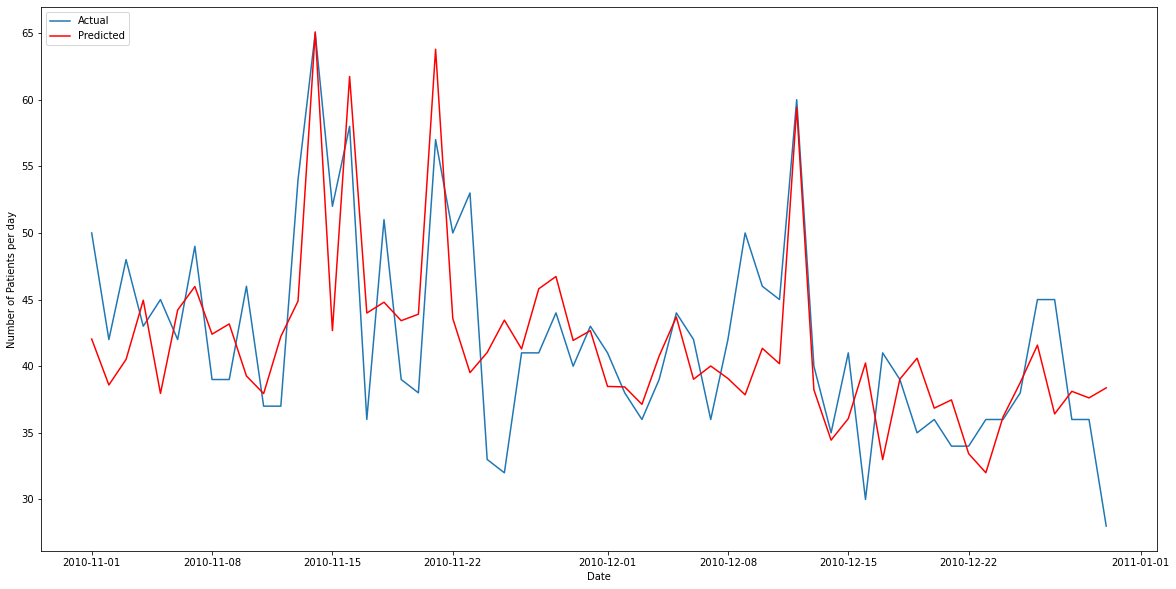

In [69]:
expected = np.array(ts_test.y)
predictions = np.array(forecast.tail(horizon).yhat)
#predictions = predictions.reshape(1,horizon)
y_test = np.array(ts_test.y)
rmse, mase , mae, mape= check_forecast(expected,predictions,y_test)
ts_predict = forecast.iloc[-horizon:,:]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#plt.plot(ts_data.ds,ts_data.y)
plt.plot(ts_test.ds,ts_test.y,label='Actual')
plt.plot(ts_predict.ds,ts_predict.yhat,color='r',label='Predicted')
plt.legend(loc="upper left")
ax.set_xlabel('Date')
ax.set_ylabel('Number of Patients per day')